# Predicting Structured Data Utilizing Multi-Layer Perceptron (MLP) and Random Forests (RF)
This is a small demonstration of two Machine Learning Models to compare its predictive power in a structured dataset (numerical images from the sikit learn library). This Jupyter Notebook is available for [download at my git repository](https://github.com/Don-Brownie/Don-Brownie.github.io/blob/main/Machine%20Learning/structured_dataset_model.ipynb). The models will be resolving the same problem with the same dataset. Data Analysis of the results will be presented in the Looker Studio section. Be mindful of the considerations of the model specified at the end of the Notebook before extrapolating these results.

# The height problem
These models will predict the height of a person based on 4 inputs: mother's height, father's height, gender (asigned at birth) and number of siblings. The training data for these models is Sir Francis Galton's height dataset published on the 1880s.

# Getting the data

We import load_digits from sklearn, the object that contains the digits dataset, as well as all other libraries that are required for this anlaysis

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
import matplotlib.pyplot as plt

galton_df = pd.read_csv(r"C:\Users\bmala\Downloads\archive\GaltonFamilies.csv")
galton_df.head()


,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5


We do not need columns rownames and family, as in our case use we will not know which family users belong, and, crucially, family could be a great indicator of non included variables (such as congenital health issues, income, etc).

In [7]:
galton_df = galton_df.drop(['rownames', 'family','childNum'], axis=1)

Lets transform heights into centimeters

In [9]:
galton_df['father'] = galton_df['father'] * 2.54
galton_df['mother'] = galton_df['mother'] * 2.54
galton_df['midparentHeight'] = galton_df['midparentHeight'] * 2.54
galton_df['childHeight'] = galton_df['childHeight'] * 2.54

One-Hot Encode column 'gender'

In [11]:
galton_df = pd.get_dummies(galton_df, columns=['gender'], drop_first=True)
galton_df['gender_male'] = galton_df['gender_male'].astype(int)

Now lets see the data distribution

In [13]:
galton_df.describe()

,father,mother,midparentHeight,children,childHeight,gender_male
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,175.760657,162.786805,175.785203,6.171306,169.534666,0.514989
std,6.290257,5.818851,4.578020,2.729025,9.091298,0.500043
min,157.480000,147.320000,163.576000,1.000000,142.240000,0.000000
25%,172.720000,160.020000,173.075600,4.000000,162.560000,0.000000
50%,175.260000,162.560000,175.889920,6.000000,168.910000,1.000000
75%,180.340000,167.322500,178.155600,8.000000,177.038000,1.000000
max,199.390000,179.070000,191.592200,15.000000,200.660000,1.000000


# Spliting the data for training and testing
The data will be split into two sub datasets, one for training, one for testing. Proportions will be 80% and 20% respectively. Do note that it is preferable to do feature engineering to save some time before doing the split (except for the validation set which should be kept separated at all times), but since im not doing feature engineering in this small example we will procede with this step right away. Predictions in the test sets will be compared later between the two models. As there is no engineering, there will also not be a validation set.

Dataset for RF

In [16]:
df_train, df_test = train_test_split(galton_df, test_size=0.2, random_state=42)

print('Rows in each Dataframe')
print('train: ', str(df_train.shape[0]))
print('test: ', str(df_test.shape[0]))

X_train = df_train.drop('childHeight', axis=1)
y_train = df_train['childHeight']

X_test = df_test.drop('childHeight', axis=1)
y_test = df_test['childHeight']

Rows in each Dataframe
train:  747
test:  187


Dataset for MLP

In [18]:
def dataframe_to_tensor(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32) 
    y_tensor = torch.tensor(y.values, dtype=torch.float32)   
    y_tensor = y_tensor.unsqueeze(1)
    tensor_dataset = TensorDataset(X_tensor, y_tensor)  
    return tensor_dataset
    
tensor_train = dataframe_to_tensor(X_train,y_train)
tensor_test = dataframe_to_tensor(X_test,y_test)

# Definiton and training of the MLP

This MLP will have two hidden fully connected layers with 250 neurons each and a ouptut layer with one neuron (only one height prediction is needed).

In [21]:
class MLP(torch.nn.Module):
    def __init__(self, input_features = X_train.shape[1], size_hidden = 250, n_output = 1):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden, bias = False)
        self.hidden2 = nn.Linear(size_hidden, size_hidden, bias = False)
        self.out = nn.Linear(size_hidden, n_output, bias = False)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

Training the MLP Model

In [23]:
device = torch.device('cpu')
net = MLP()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters() , lr=learning_rate)
criterion = torch.nn.MSELoss()
num_epochs = 150
loader = DataLoader(dataset=tensor_train, batch_size=40, shuffle=True)

# Defining the forward and backward process
for i in range(num_epochs):
    for x, y in loader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        loss = criterion(net(x), y)
        loss.backward()
        optimizer.step()
        
torch.save(net.state_dict(), "./mlp2.pth")

Predicting in the test dataset with the CNN and obtaining the i

C:\Users\bmala\AppData\Local\Temp\ipykernel_14916\2391143686.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./mlp2.pth"))


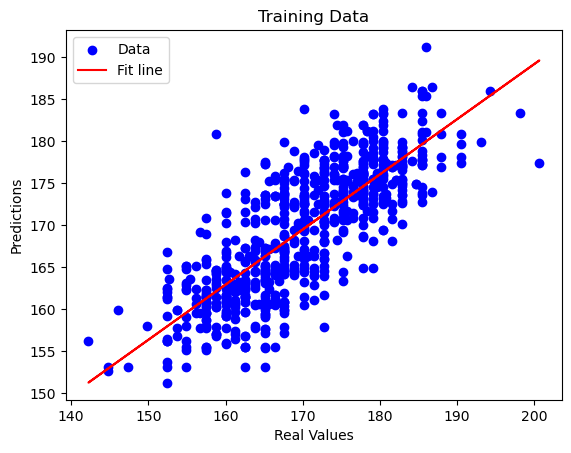

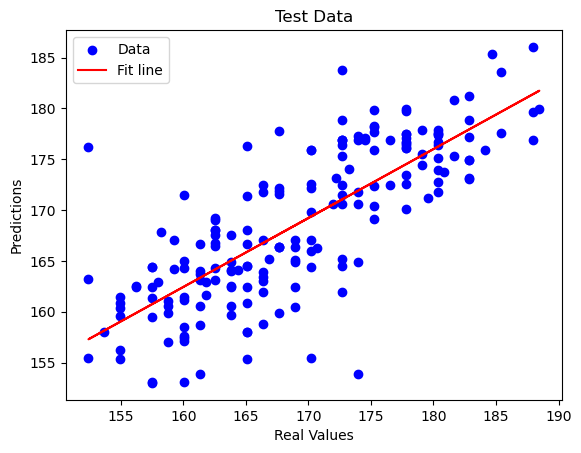

Mean Squared Error on Training Data: 31.451101303100586
Mean Squared Error on Test Data: 30.70365333557129


In [25]:
# Load model
net.load_state_dict(torch.load("./mlp2.pth"))
net.to(device)

loader_train = DataLoader(dataset=tensor_train, batch_size=100, shuffle=False)
loader_test = DataLoader(dataset=tensor_test, batch_size=100, shuffle=False)

# Method to plot scatter plot with regression line
def plotScatter(x_data, y_data, title, fit_line=True,datatype = "tensor"):
    plt.figure()
    plt.scatter(x_data, y_data, color='blue', label="Data")
    plt.xlabel('Real Values')
    plt.ylabel('Predictions')
    plt.title(title)

    if fit_line:
        if datatype == "tensor":
            X, Y = x_data.reshape(-1, 1), y_data.reshape(-1, 1)
        else:
            X,Y = x_data.values.reshape(-1, 1), y_data
        plt.plot(X, LinearRegression().fit(X, Y).predict(X), color='red', label="Fit line")
    
    plt.legend()
    plt.show()

# Extract training and test data from the dataloaders
def get_predictions(loader):
    all_preds = []
    all_labels = []
    all_features = []
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Ensure data is on the correct device
            preds = net(x_batch).cpu().numpy()  # Predict and move back to CPU
            all_preds.append(preds)
            all_labels.append(y_batch.cpu().numpy())  # Move labels back to CPU
            all_features.append(x_batch.cpu().numpy())  # Store feature data
    
    return np.concatenate(all_features), np.concatenate(all_labels), np.concatenate(all_preds)

# Get predictions for training data
X_train_data, y_train_tensor, y_pred_train = get_predictions(loader_train)
plotScatter(y_train_tensor, y_pred_train, "Training Data")

# Get predictions for test data
X_test_data, y_test_tensor, y_pred_test = get_predictions(loader_test)
plotScatter(y_test_tensor, y_pred_test, "Test Data")

# Calculate and print the Mean Squared Error for both train and test data
train_mse = ((y_train_tensor - y_pred_train) ** 2).mean()
test_mse = ((y_test_tensor - y_pred_test) ** 2).mean()

print(f"Mean Squared Error on Training Data: {train_mse}")
print(f"Mean Squared Error on Test Data: {test_mse}")

train_df_mlp = pd.DataFrame(X_train_data, columns=[f"Feature_{i+1}" for i in range(X_train_data.shape[1])])  # Assign columns for features
train_df_mlp['True Value'] = y_train_tensor.flatten()
train_df_mlp['Predicted Value'] = y_pred_train.flatten()
train_df_mlp['Dataset'] = 'train'  # Label as 'train'

# For test data:
test_df_mlp = pd.DataFrame(X_test_data, columns=[f"Feature_{i+1}" for i in range(X_test_data.shape[1])])  # Assign columns for features
test_df_mlp['True Value'] = y_test_tensor.flatten()
test_df_mlp['Predicted Value'] = y_pred_test.flatten()
test_df_mlp['Dataset'] = 'test'  # Label as 'test'

# Combine both DataFrames into one
mlp_df = pd.concat([train_df_mlp, test_df_mlp], ignore_index=True)

# Save the DataFrame to a CSV file
mlp_df.to_csv('mlp_predictions.csv', index=False)



# Definiton and training of the RF

In [77]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, 'height_random_forest_model.joblib_1')

['height_random_forest_model.joblib_1']

Predicting in the test dataset with the RF and obtaining its outputs

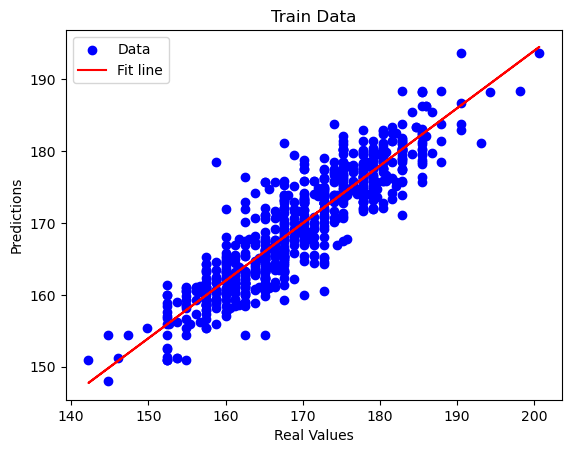

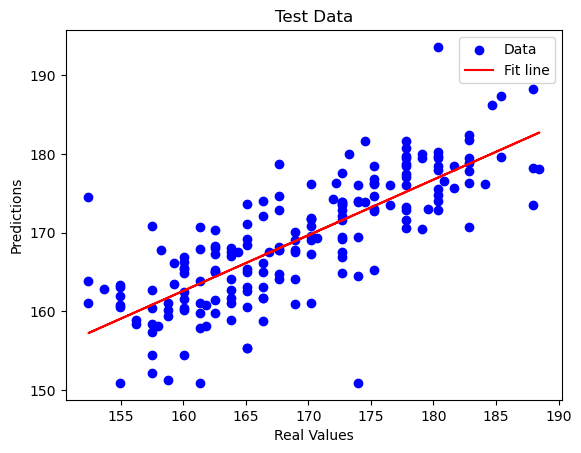

Mean Squared Error on Train Data: 15.50646187454997
Mean Squared Error on Test Data: 31.1374695913187


In [80]:
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
plotScatter(y_train, y_pred_train_rf, "Train Data",datatype="dataframe")
plotScatter(y_test, y_pred_test_rf, "Test Data",datatype="dataframe")
train_mse_rf = ((y_train - y_pred_train_rf) ** 2).mean()
test_mse_rf = ((y_test - y_pred_test_rf) ** 2).mean()
print(f"Mean Squared Error on Train Data: {train_mse_rf}")
print(f"Mean Squared Error on Test Data: {test_mse_rf}")

train_df_rf = pd.DataFrame(X_train, columns=[f"Feature_{i+1}" for i in range(X_train.shape[1])])  # Assign columns for features
train_df_rf['True Value'] = y_train  # Directly use y_train, no need to flatten
train_df_rf['Predicted Value'] = y_pred_train_rf
train_df_rf['Dataset'] = 'train'  # Label as 'train'

# Create DataFrame for test data
test_df_rf = pd.DataFrame(X_test, columns=[f"Feature_{i+1}" for i in range(X_test.shape[1])])  # Assign columns for features
test_df_rf['True Value'] = y_test  # Directly use y_test, no need to flatten
test_df_rf['Predicted Value'] = y_pred_test_rf
test_df_rf['Dataset'] = 'test'  # Label as 'test'

rf_df = pd.concat([train_df_rf, test_df_rf], ignore_index=True)
rf_df.to_csv('rf_predictions.csv', index=False)


# Conclusions, Reflections and Warnings

You might notice that the code for the MLP is significantly more complex than the code for Random Forests. This was a deliberate decision to showcase my understanding of the inner workings of a CNN. In truth, there are services available that can make the MLP just as simple to code as the Random Forest. Both of these models are complex to code from scratch, but that's the beauty of using public libraries.

In this example with structured data, both the MLP and Random Forest had similar performance in testing, with an MSE of around 30. However, the Random Forest performed better in terms of the training MSE. This is likely due to overfitting.

Things to Consider:
- The dataset is very small.
- No feature engineering was applied (which is generally recommended for Random Forests).
- There was no hyperparameter optimization, nor any tweaking of the model structure.
- The dataset dates back to the 1880s.